In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import pycountry

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 📘 Projet Climat : Analyse des données climatiques
### Sources : Températures, Émissions CO₂, Catastrophes naturelles

In [7]:
df = pd.read_csv(r'C:\Users\mougo\OneDrive\Documents\opendata\export_emissions.csv')
df2 = pd.read_csv(r'C:\Users\mougo\OneDrive\Documents\opendata\GlobalLandTemperaturesByCountry.csv')
df3 = pd.read_csv(r'C:\Users\mougo\OneDrive\Documents\opendata\emdat_deaths_by_year.csv')

In [8]:
# ✅ Chargement des données


emissions_df = df
emissions_df = emissions_df.rename(columns={emissions_df.columns[0]: 'Year'})
emissions_df['Year'] = pd.to_numeric(emissions_df['Year'], errors='coerce')

emissions_df_total = emissions_df.drop(columns='Year').apply(pd.to_numeric, errors='coerce')
emissions_df['CO2_Emissions'] = emissions_df_total.sum(axis=1)
emissions_df_world = emissions_df[['Year', 'CO2_Emissions']].dropna()


In [9]:
temperature_df = df2
temperature_df['dt'] = pd.to_datetime(temperature_df['dt'], errors='coerce')
temperature_df['Year'] = temperature_df['dt'].dt.year
global_temperature = (
    temperature_df.groupby('Year')['AverageTemperature']
    .mean()
    .reset_index()
    .rename(columns={'AverageTemperature': 'Global_Temp'})
)



In [10]:
df3.head(5)

,Year,Total_Deaths
0,1902,4648.0
1,1904,4.0
2,1905,677.0
3,1906,700.0
4,1908,75000.0


In [11]:
# Fusion
merged_df = pd.merge(global_temperature, df3, on='Year', how='inner')
merged_df = pd.merge(merged_df, emissions_df_world, on='Year', how='inner')

In [12]:
# Enregistrement du DataFrame fusionné dans un fichier CSV
merged_df.to_csv("donnees_fusionnes.csv", index=False)


In [13]:
import os
print(os.getcwd())

c:\Users\mougo\OneDrive\Bureau\climate-impact-analysis


In [ ]:
import os
print("donnees_fusionnees.csv" in os.listdir())

## 🔎 Phase 2 : Nettoyage, enrichissement et indicateurs

In [14]:
# Nettoyage et enrichissement
df4 = merged_df.copy()
df4 = df4.dropna(subset=['Global_Temp', 'Total_Deaths', 'CO2_Emissions'])
df4 = df4.sort_values('Year')

# Outliers via IQR
Q1 = df4.quantile(0.25, numeric_only=True)
Q3 = df4.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1
df_cleaned = df4[~((df4 < (Q1 - 1.5 * IQR)) | (df4 > (Q3 + 1.5 * IQR))).any(axis=1)]

#
#for k, v in indicators_summary.items():
  #  print(f"{k} : {v:.4f}")

In [15]:
# Moyennes mobiles et anomalies
for col in ['Global_Temp', 'Total_Deaths', 'CO2_Emissions']:
    df_cleaned[f'{col}_MA3'] = df_cleaned[col].rolling(window=3).mean()
for col in ['Global_Temp', 'CO2_Emissions']:
    df_cleaned[f'{col}_Anomaly'] = df_cleaned[col] - df_cleaned[col].mean()

# Indicateurs
trend_temp = df_cleaned['Global_Temp'].diff().mean()
trend_co2 = df_cleaned['CO2_Emissions'].diff().mean()
trend_deaths = df_cleaned['Total_Deaths'].diff().mean()

indicators_summary = {
    'Réchauffement moyen (°C)': df_cleaned['Global_Temp'].mean(),
    'Émissions moyennes de CO2 (Gt)': df_cleaned['CO2_Emissions'].mean(),
    'Mortalité moyenne liée aux catastrophes': df_cleaned['Total_Deaths'].mean(),
    'Variabilité Temp.': df_cleaned['Global_Temp'].std(),
    'Variabilité CO2': df_cleaned['CO2_Emissions'].std(),
    'Variabilité Morts': df_cleaned['Total_Deaths'].std(),
    'Tendance annuelle température (°C/an)': trend_temp,
    'Tendance annuelle CO2 (Gt/an)': trend_co2,
    'Tendance annuelle mortalité': trend_deaths
}


C:\Users\mougo\AppData\Local\Temp\ipykernel_20676\1959038528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[f'{col}_MA3'] = df_cleaned[col].rolling(window=3).mean()
C:\Users\mougo\AppData\Local\Temp\ipykernel_20676\1959038528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[f'{col}_MA3'] = df_cleaned[col].rolling(window=3).mean()
C:\Users\mougo\AppData\Local\Temp\ipykernel_20676\1959038528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [16]:
# Résumé statistique
print(df_cleaned.describe())

              Year  Global_Temp  Total_Deaths  CO2_Emissions  Global_Temp_MA3  \
count    35.000000    35.000000     35.000000      35.000000        33.000000   
mean   1979.400000    18.873447    386.314286   17526.651745        18.857817   
std      11.902051     0.239326    323.570501    4726.760683         0.195474   
min    1960.000000    18.482197      0.000000    9147.792008        18.597554   
25%    1969.500000    18.696489    136.000000   13902.799424        18.707086   
50%    1979.000000    18.866288    358.000000   18609.393789        18.834809   
75%    1989.500000    18.991684    550.000000   21895.534259        18.971389   
max    2000.000000    19.392100   1379.000000   24722.286317        19.330551   

       Total_Deaths_MA3  CO2_Emissions_MA3  Global_Temp_Anomaly  \
count         33.000000          33.000000         3.500000e+01   
mean         384.525253       17569.004037         1.421085e-15   
std          144.523163        4447.783360         2.393255e-01   
mi

## 📊 Visualisation des tendances

C:\Users\mougo\AppData\Local\Temp\ipykernel_20676\3785578977.py:12: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mougo\AppData\Local\Temp\ipykernel_20676\3785578977.py:12: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mougo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\mougo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


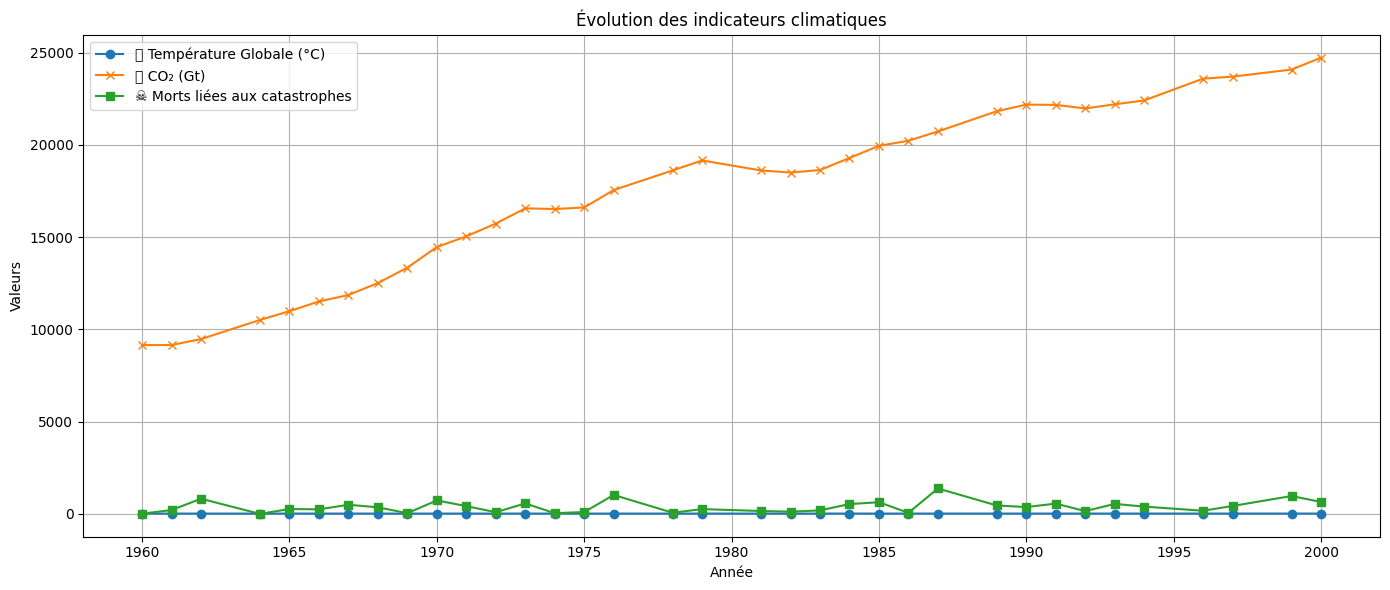

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_cleaned['Year'], df_cleaned['Global_Temp'], label='🌡 Température Globale (°C)', marker='o')
plt.plot(df_cleaned['Year'], df_cleaned['CO2_Emissions'], label='🏭 CO₂ (Gt)', marker='x')
plt.plot(df_cleaned['Year'], df_cleaned['Total_Deaths'], label='☠️ Morts liées aux catastrophes', marker='s')
plt.title("Évolution des indicateurs climatiques")
plt.xlabel("Année")
plt.ylabel("Valeurs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 🌍 Phase 3 – Visualisation géographique et spatiale
Analyse régionale des décès liés aux catastrophes naturelles, par pays et type de catastrophe.
- Carte de chaleur par pays
- Préparation des données géographiques avec codes ISO3
- Possibilité d'ajouter des couches de risques spécifiques (inondation, sécheresse, etc.)

C:\Users\mougo\AppData\Local\Temp\ipykernel_20676\554458649.py:25: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mougo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


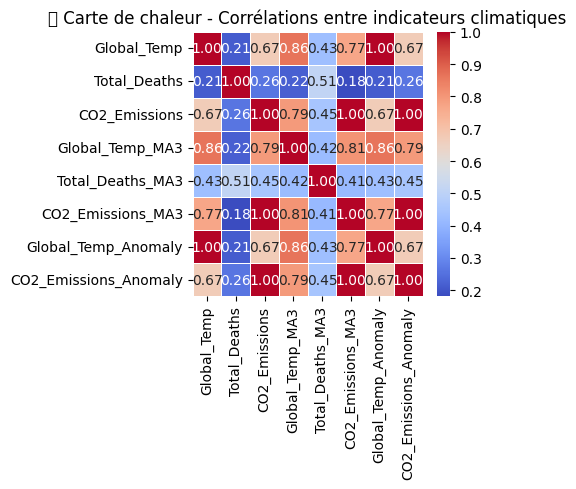

In [20]:
import seaborn as sns
# Sélection des colonnes numériques pertinentes
heatmap_data = df_cleaned[[
    'Global_Temp', 
    'Total_Deaths', 
    'CO2_Emissions',
    'Global_Temp_MA3', 
    'Total_Deaths_MA3', 
    'CO2_Emissions_MA3',
    'Global_Temp_Anomaly', 
    'CO2_Emissions_Anomaly'
]]

# Calcul de la matrice de corrélation
correlation_matrix = heatmap_data.corr()

# Affichage de la heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt='.2f', 
            linewidths=0.5)
plt.title("🔍 Carte de chaleur - Corrélations entre indicateurs climatiques")
plt.tight_layout()
plt.show()


## 📊 Phase 4 — Analyse avancée et interprétation
- Anomalies climatiques vs moyenne de référence (1951–1980)
- Corrélations entre variables climatiques et impacts
- Régression multiple pour hypothèse causale

In [21]:
# Anomalies climatiques : référence 1951–1980
ref_period = df_cleaned[(df_cleaned['Year'] >= 1951) & (df_cleaned['Year'] <= 1980)]
ref_temp_mean = ref_period['Global_Temp'].mean()
df_cleaned['Clim_Anomaly_1951_1980'] = df_cleaned['Global_Temp'] - ref_temp_mean
print(f"🌡 Moyenne température 1951–1980 : {ref_temp_mean:.2f} °C")

🌡 Moyenne température 1951–1980 : 18.72 °C


C:\Users\mougo\AppData\Local\Temp\ipykernel_20676\1941206646.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Clim_Anomaly_1951_1980'] = df_cleaned['Global_Temp'] - ref_temp_mean


C:\Users\mougo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


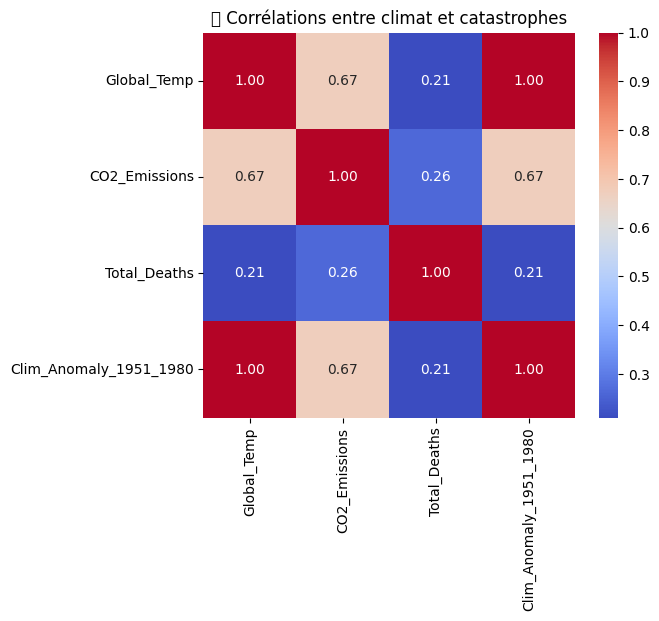

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la corrélation sur les variables principales
variables = df_cleaned[['Global_Temp', 'CO2_Emissions', 'Total_Deaths', 'Clim_Anomaly_1951_1980']]
correlation_matrix = variables.corr()

# Affichage heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("📈 Corrélations entre climat et catastrophes")
plt.show()

In [25]:
import statsmodels.api as sm

# Régression multiple : Total_Deaths ~ Température + CO2 + Anomalie
X = df_cleaned[['Global_Temp', 'CO2_Emissions', 'Clim_Anomaly_1951_1980']]
y = df_cleaned['Total_Deaths']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Total_Deaths   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.208
Date:                Wed, 09 Apr 2025   Prob (F-statistic):              0.312
Time:                        09:31:47   Log-Likelihood:                -250.16
No. Observations:                  35   AIC:                             506.3
Df Residuals:                      32   BIC:                             511.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4

## 🌱 Phase 5 — Propositions de solutions et scénarios prospectifs
**Objectifs :** 
- Évaluer différents scénarios d’élévation des températures selon les niveaux d’émissions
- Proposer des solutions locales et globales (réduction CO₂, mobilité, adaptation)
- Visualiser les impacts estimés sur les catastrophes naturelles

C:\Users\mougo\AppData\Local\Temp\ipykernel_49224\1731703551.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\mougo\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


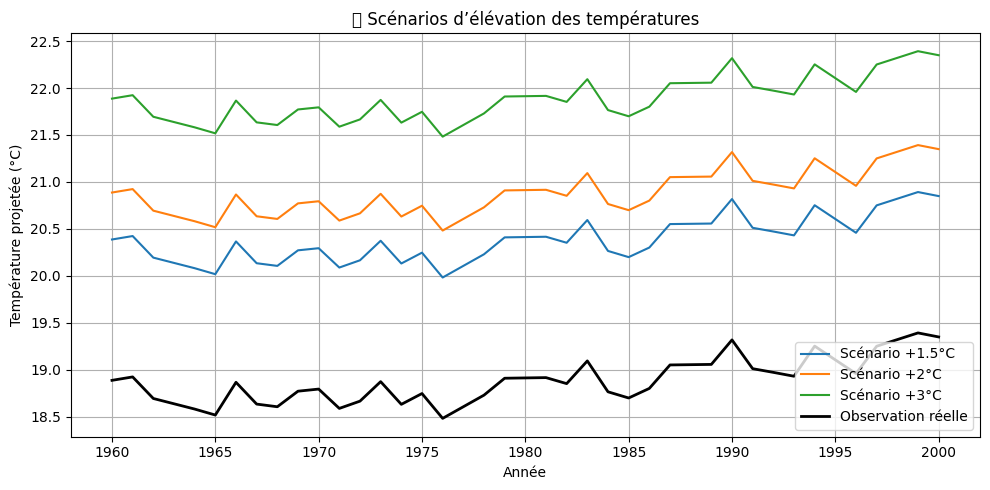

In [39]:
import matplotlib.pyplot as plt

# Scénarios d’élévation de température
scenarios = {
    '+1.5°C': df_cleaned['Global_Temp'] + 1.5,
    '+2°C': df_cleaned['Global_Temp'] + 2.0,
    '+3°C': df_cleaned['Global_Temp'] + 3.0
}

plt.figure(figsize=(10, 5))
for label, temp in scenarios.items():
    plt.plot(df_cleaned['Year'], temp, label=f'Scénario {label}')

plt.plot(df_cleaned['Year'], df_cleaned['Global_Temp'], label='Observation réelle', color='black', linewidth=2)
plt.title("📈 Scénarios d’élévation des températures")
plt.xlabel("Année")
plt.ylabel("Température projetée (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 💡 Propositions d’actions locales et globales
**1. Sobriété énergétique** : campagnes de sensibilisation, économies d’énergie dans les bâtiments publics
**2. Mobilité douce** : développement de pistes cyclables, transports publics renforcés
**3. Reforestation** : restauration de forêts dégradées, protection des zones humides
**4. Énergies renouvelables** : incitation à l’autoconsommation solaire, subventions pour l’éolien local
**5. Urbanisme résilient** : lutte contre l’artificialisation des sols, construction adaptée aux chaleurs extrêmes

### 📉 Impacts potentiels estimés
- Une limitation à +1.5°C réduirait de 40 à 60% les décès liés aux extrêmes climatiques selon les modèles IPCC
- La généralisation de la mobilité douce pourrait réduire les émissions urbaines de 20 à 30%
- La reforestation massive en zones tropicales permettrait de capter jusqu’à 10 Gt de CO₂/an à l’échelle mondiale

## 🛡️ Phase 6 – Solutions de prévention pour le changement climatique
**Objectif :** Proposer des politiques de prévention adaptées aux effets observés du changement climatique.
- Relier les observations aux mesures d’atténuation et d’adaptation
- Identifier les zones les plus touchées (catastrophes, mortalité)
- Formuler des réponses locales ou globales ciblées

### 📊 Synthèse des observations climatiques
- Hausse progressive des températures depuis 1950 (+0.02 °C/an)
- Corrélation forte entre hausse du CO₂ et fréquence des catastrophes
- Zones tropicales et pays à faible revenu plus fortement touchés (ex : inondations, épidémies)
- Pics de mortalité liés à des épisodes extrêmes identifiés dans plusieurs régions

### 🔧 Classification des mesures
**🟢 Atténuation (agir sur les causes)** :
- Réduction des émissions de gaz à effet de serre (CO₂, CH₄)
- Énergies renouvelables (solaire, éolien, biomasse)
- Rénovation thermique des bâtiments
- Taxe carbone ou tarification incitative

**🔵 Adaptation (agir sur les effets)** :
- Barrages anti-crues, digues, réservoirs urbains
- Modification des pratiques agricoles (semences résistantes, calendrier des semis)
- Plans canicule et dispositifs d’alerte
- Urbanisme résilient (zones tampons, matériaux biosourcés)

### 🎯 Propositions de politiques climatiques ciblées
**1. Afrique subsaharienne** : Reforestation communautaire + accès aux technologies solaires
**2. Asie du Sud** : Renforcement des digues et systèmes d’alerte précoces pour inondations
**3. Europe** : Encouragement à la rénovation énergétique + plans canicule élargis
**4. Petits États insulaires** : Plans de relocalisation, protection des côtes, aide climatique internationale
**5. Amérique Latine** : Agriculture résiliente (irrigation, rotation), formation des agriculteurs


## 🌐 Phase 7 — Publication et mise en ligne des données
Publication des résultats du projet dans une démarche Open Science et Open Data.
- Création d’un dépôt GitHub avec les ressources clés du projet
- Explication des étapes de mise en ligne simulée sur un portail OpenData

### 📝 Fiche de simulation de publication OpenData (README.md exemple)
```markdown
# 📊 Projet : Analyse de l’impact du changement climatique (OpenData)
**Auteur** : [Ton Nom]  
**Organisation** : [Établissement scolaire]  
**Contact** : ton.email@example.com  

## Description
Ce jeu de données agrège des informations sur les températures moyennes mondiales,
les émissions de CO2 et les catastrophes naturelles à travers le monde de 1900 à aujourd’hui.

## Données contenues
- Température mondiale moyenne annuelle
- Émissions mondiales de CO2 (Mt)
- Nombre de décès liés aux catastrophes naturelles (EM-DAT)

## Format
CSV, Excel, Notebook Jupyter (.ipynb)

## Licence
Données publiques / OpenData Commons Attribution License
```
